<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/generate_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import random
import cv2
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
#from transformers import AutoModel, AutoTokenizer

In [108]:
def f_createRandomImage():
    x,y = 100,100
    max_r = 20
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((102, 204, 0),1),((0, 51, 204),2),((204, 0, 204),3),((204, 0, 0),4)]
    lst_res = []
    for color in colors:
        for i in range(3000):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(10,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame.flatten(), locx-r, locy-r, locx + r, locy + r, color[1]/10])
            #cv2.waitKey(0)

    return lst_res

In [81]:
class cls_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1,128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,100*100*3),
            #nn.ReLU(),
            #nn.Linear(1000,100*100*3)
        )

    def forward(self,x):

        y = self.model.forward(x)

        return y

In [68]:
class cls_data(Dataset):
    def __init__(self,df) -> None:
        super().__init__()

        self.dataset = df

        print("Head of dataset: ", self.dataset.head(2))
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "c"]).unsqueeze(dim=0), torch.tensor(self.dataset.loc[index, "image"])

In [109]:
lst_data = f_createRandomImage()
df1 = pd.DataFrame({"image":[i[0] for i in lst_data], "c":[i[5] for i in lst_data]})

df_train , df_test = train_test_split(df1,test_size=.01,stratify=df1.c)

ds_train = cls_data(df_train.reset_index().drop(columns=["index"]))

ds_test = cls_data(df_test.reset_index().drop(columns=["index"]))

trainLoader = DataLoader(ds_train,batch_size=8)
testLoader = DataLoader(ds_test,batch_size=8)

Head of dataset:                                                 image    c
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.3
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.0
Head of dataset:                                                 image    c
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.0
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.2


In [87]:
ds_train[1][1].shape

torch.Size([30000])

In [110]:
def f_train(net, criterion, trainLoader, valLoader, optim, device):

    net = net.to(device)
    for ep in range(20):
        for x_batch, y_batch in trainLoader:
            
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).float()

            predict = net(x_batch)
            
            loss = criterion(predict, y_batch)
            optim.zero_grad()

            loss.backward()
            optim.step()           
        
        print("loss", loss)

In [111]:
net = cls_model()

criterion = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [112]:
f_train(net, criterion, trainLoader,testLoader,optim, device)

loss tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss tensor(0.0179, devic

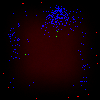

In [118]:
a= net(torch.tensor([[.4]]).to(device))
Image.fromarray( (a[0]*255).type(torch.uint8).cpu().numpy().reshape(100,100,3))

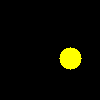

In [48]:
Image.fromarray(lst_data[42][0].astype(np.uint8).reshape(100,100,3)*255)